In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/su/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

In [3]:
def cross_dot(b):
    # d(axb)/d(a)
    cross_dot = np.array([[0, b[2], -b[1]],
                    [-b[2], 0, b[0]],
                    [b[1], -b[0], 0]])
    return cross_dot

def cross2_dot(a, b):
    #d(ax(axb))/d(a)
    cross2_dot = np.array([[a[1]*b[1]+a[2]*b[2], a[0]*b[1]-2*a[1]*b[0], a[0]*b[2]-2*a[2]*b[0]],
                           [-2*a[0]*b[1]+a[1]*b[0], a[0]*b[0]+a[2]*b[2], a[1]*b[2]-2*a[2]*b[1]],
                           [-2*a[0]*b[2]+a[2]*b[0], -2*a[1]*b[2]+a[2]*b[1], a[0]*b[0]+a[1]*b[1]]])
    return cross2_dot
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

In [4]:
def dynamics(dt, state, RW, w_input_noise, a_input_noise, sf):
    state_next = np.zeros(9) 
    state_next[0:3] = state[0:3] + state[3:6] * dt + RW * np.random.randn(3)           # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                               # omega_dot
    state_next[6:9] = sf + a_input_noise * np.random.randn(3)                          # specific force
    return state_next

def dynamics_est(dt, state, sf):
    state_next = np.zeros(9)
    state_next[0:3] = state[0:3] + state[3:6] * dt          # omega
    state_next[3:6] = np.zeros(3)                           # omega_dot
    state_next[6:9] = sf                                    # specific force
    return state_next

def Jacobian_f(dt):
    F = np.zeros((9, 9))
    F[0:3, 0:3]            = np.eye(3)
    F[0:3, 3:6]            = dt * np.eye(3)
    return F

In [5]:
def measurement(state, pos_r, Rb_si, WN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*num_imus:3+i*num_imus]*np.random.randn(3))
        omega_i = Rb_si_sub @ omega + WN[3+i*num_imus:6+i*num_imus]*np.random.randn(3)
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas


def measurement_est(state, pos_r, Rb_si, num_imus):
    meas = np.zeros(6*num_imus)
    H = np.zeros((6*num_imus, 9))
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        H_i = np.zeros((6, 9))
        H_i[0:3, 0:3] = Rb_si_sub @ cross2_dot(omega, r_sub)
        H_i[0:3, 3:6] = Rb_si_sub @ cross_dot(r_sub)
        H_i[0:3, 6:9] = Rb_si_sub
        H_i[3:6, 0:3] = Rb_si_sub
        meas[i*6:6+i*6] = H_i @ state
        H[i*6:6+i*6, :] = H_i
    return meas, H

In [6]:
# measurements
measurements = np.array(read_txt("data/imu.txt"))

In [7]:
num_imus = 3

# Other DISI Kit params
# Positions in 3xN where each column is position of 1 IMU
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0]])
Rb_si = [np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix

w_input_noise = 0
a_input_noise = 0
RW = 1e-4
WN = 1e-3 * np.ones(6*num_imus)

dt = 0.01
time = np.arange(0, 360, 0.01)

# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(9)
state_est = np.zeros(9)
omega = np.array([1, 1, 1])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 1])
state_est[0:3] = omega
state_est[6:9] = sf
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9))
state_est_hist = np.zeros((len(time), 9))
meas = np.zeros(6*num_imus)
meas_hist = np.zeros((len(time),6*num_imus))

# Initial state Coveriance
P_est = np.eye(9)

# Covariance of process noise covariance
Q = np.zeros((9, 9))
Q[0:3,0:3] = RW ** 2 * np.eye(3)
Q[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
Q[6:9,6:9] = a_input_noise ** 2 * np.eye(3)

# Covariance of measurement noise covariance
R = np.eye(6*num_imus)*WN**2

for i in range(len(time)):
    state = dynamics(dt, state, RW, w_input_noise, a_input_noise, sf)
    state_hist[i] = state

    # Prediction step
    state_pred = dynamics_est(dt, state_est, sf)
    F = Jacobian_f(dt)
    P_pred = np.dot(np.dot(F, P_est), F.T) + Q
    P_first = P_est

    # Update step
    meas, H = measurement_est(state_pred, pos_r, Rb_si, num_imus)
    y = measurements[i] - meas
    S = np.dot(np.dot(H, P_pred), H.T) + R
    K = np.dot(np.dot(P_pred, H.T), np.linalg.inv(S))
    state_est = state_pred + np.dot(K, y)
    P_est = np.dot(np.eye(len(P_est))- np.dot(K,H), P_pred)
    meas_hist[i] = meas
    state_est_hist[i] = state_est

Text(0.5, 1.0, 'omega')

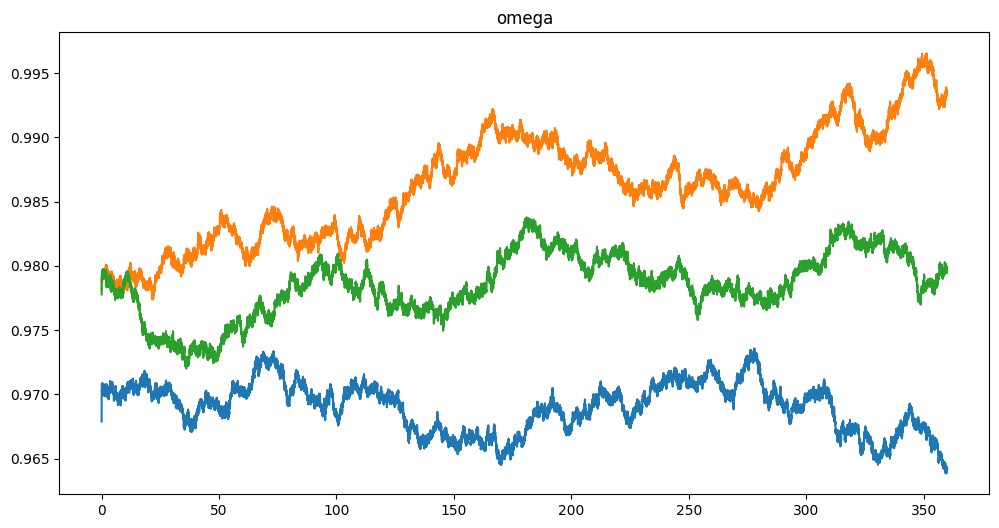

In [8]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,0])
plt.plot(time, state_est_hist[:,1])
plt.plot(time, state_est_hist[:,2])
plt.title("omega")

Text(0.5, 1.0, 'omega dot')

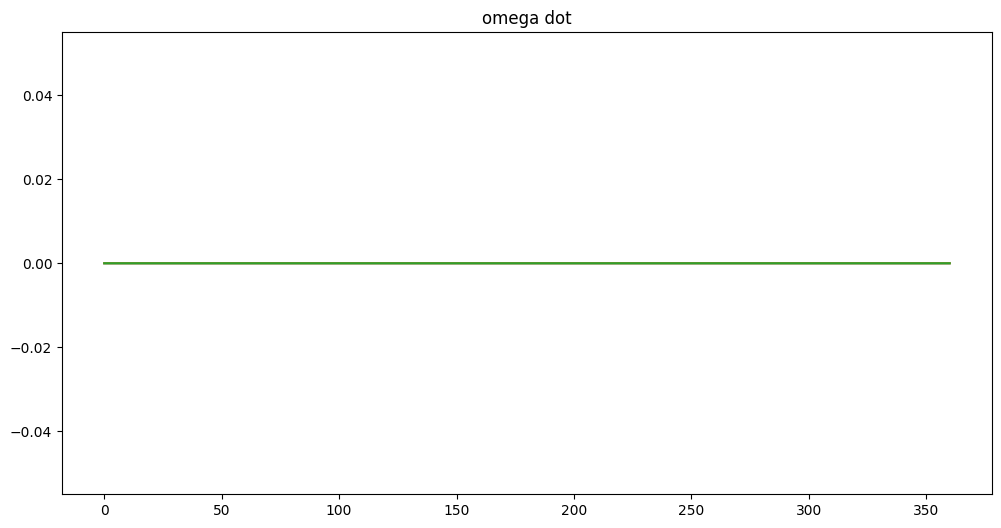

In [9]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,3])
plt.plot(time, state_est_hist[:,4])
plt.plot(time, state_est_hist[:,5])
plt.title("omega dot")

Text(0.5, 1.0, 'specific force')

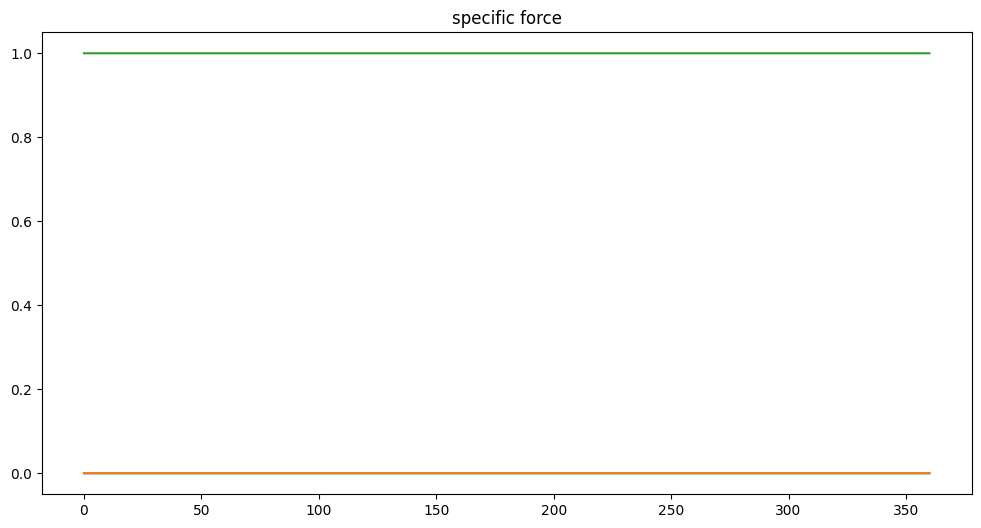

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,6])
plt.plot(time, state_est_hist[:,7])
plt.plot(time, state_est_hist[:,8])
plt.title("specific force")

Text(0.5, 1.0, 'omega')

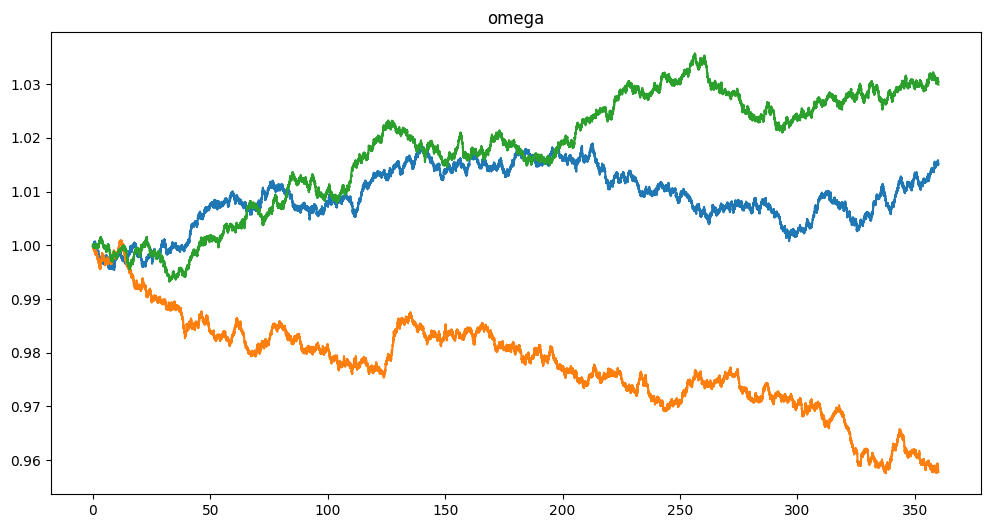

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_hist[:,0])
plt.plot(time, state_hist[:,1])
plt.plot(time, state_hist[:,2])
plt.title("omega")

Text(0.5, 1.0, 'omega dot')

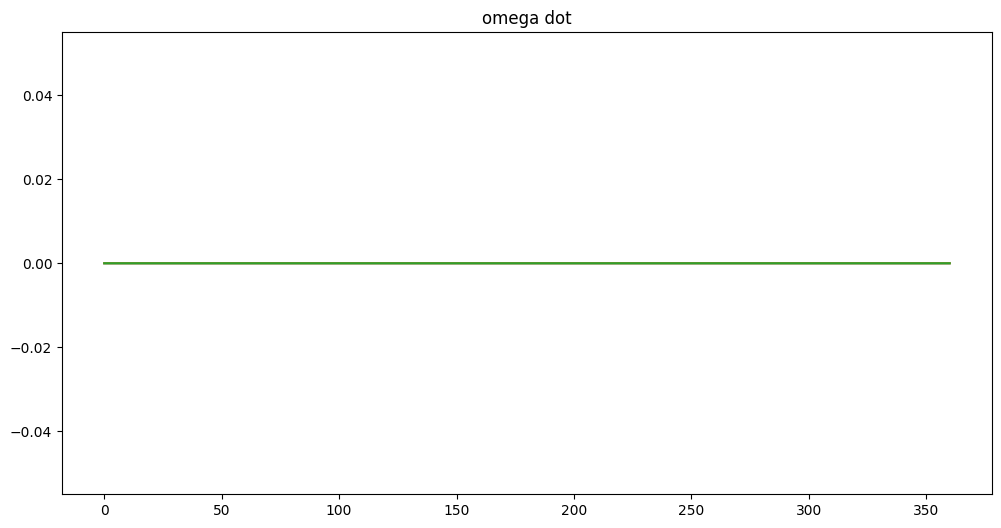

In [12]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_hist[:,3])
plt.plot(time, state_hist[:,4])
plt.plot(time, state_hist[:,5])
plt.title("omega dot")

Text(0.5, 1.0, 'specific force')

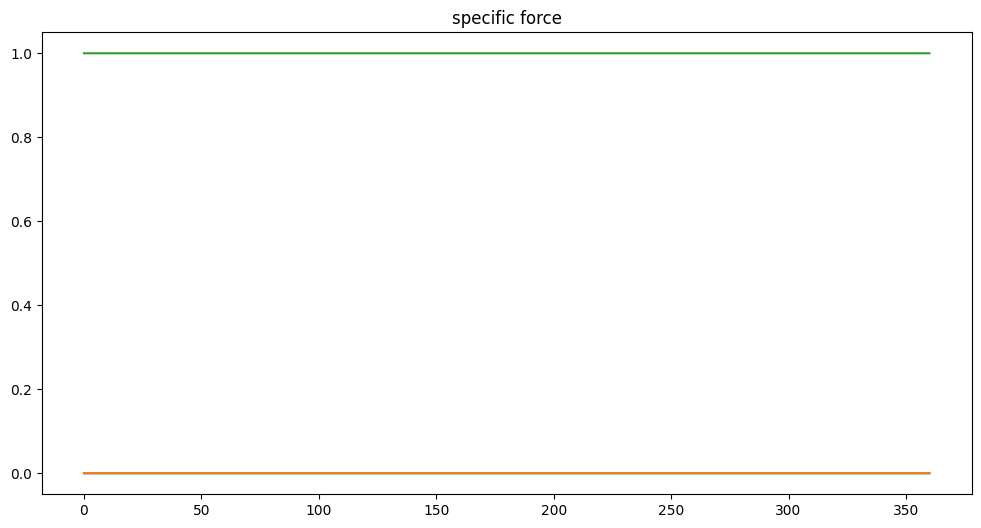

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_hist[:,6])
plt.plot(time, state_hist[:,7])
plt.plot(time, state_hist[:,8])
plt.title("specific force")

Text(0.5, 1.0, 'specific force measurement estimates')

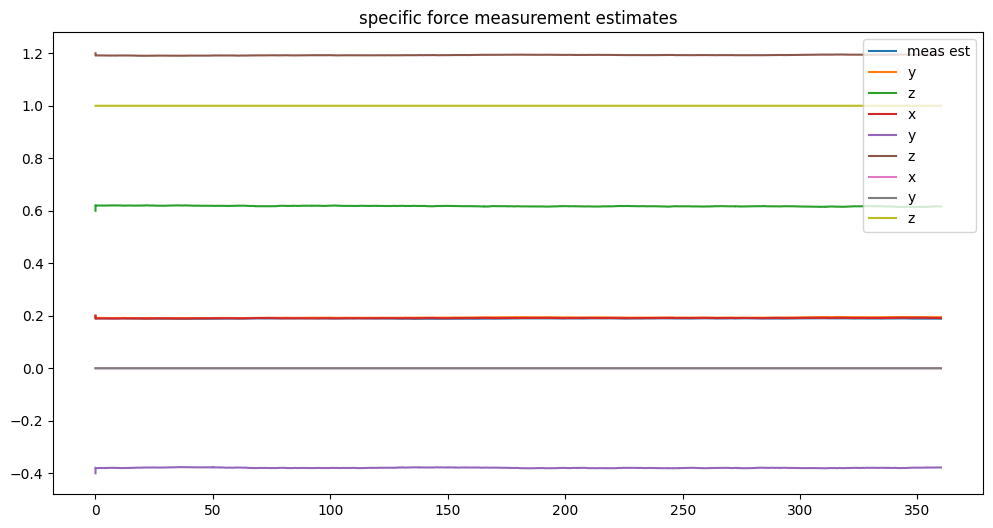

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(time, meas_hist[:,0], label = 'meas est')
plt.plot(time, meas_hist[:,1], label = 'y')
plt.plot(time, meas_hist[:,2], label = 'z')
plt.plot(time, meas_hist[:,6], label = 'x')
plt.plot(time, meas_hist[:,7], label = 'y')
plt.plot(time, meas_hist[:,8], label = 'z')
plt.plot(time, meas_hist[:,12], label= 'x')
plt.plot(time, meas_hist[:,13], label= 'y')
plt.plot(time, meas_hist[:,14], label= 'z')
plt.legend()
plt.title("specific force measurement estimates")